In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should be False on CPU-only


2.2.2
False


In [10]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt


In [15]:
from torch.utils.data import Dataset
import os
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image




In [18]:
import zipfile
import os

zip_path = 'F:/computer vision/Eyes.zip'
extract_to = 'F:/computer vision/Eyes'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted successfully.")


Extracted successfully.


In [ ]:
dataset = MyDataset(r'F:/computer vision/Eyes')


In [20]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]


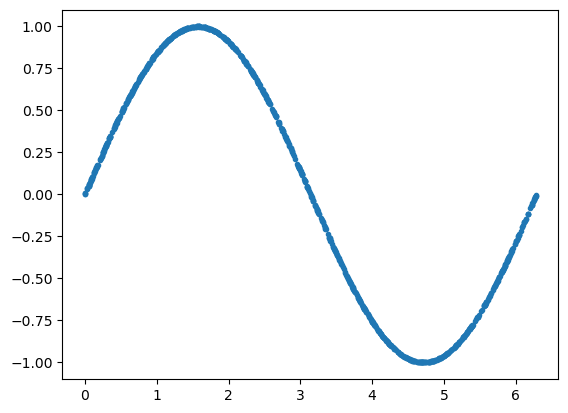

In [21]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")


In [22]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [24]:
discriminator = Discriminator()


In [25]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()


In [26]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()


In [27]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [28]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.1785350739955902
Epoch: 0 Loss G.: 2.0996975898742676
Epoch: 10 Loss D.: 0.7121888995170593
Epoch: 10 Loss G.: 1.09730064868927
Epoch: 20 Loss D.: 0.6232489943504333
Epoch: 20 Loss G.: 0.8183892965316772
Epoch: 30 Loss D.: 0.6540062427520752
Epoch: 30 Loss G.: 0.7324798703193665
Epoch: 40 Loss D.: 0.7030712366104126
Epoch: 40 Loss G.: 0.6298189163208008
Epoch: 50 Loss D.: 0.7324383854866028
Epoch: 50 Loss G.: 0.612528920173645
Epoch: 60 Loss D.: 0.7083463072776794
Epoch: 60 Loss G.: 0.6750767230987549
Epoch: 70 Loss D.: 0.6747036576271057
Epoch: 70 Loss G.: 0.6621093153953552
Epoch: 80 Loss D.: 0.6786369681358337
Epoch: 80 Loss G.: 0.8307213187217712
Epoch: 90 Loss D.: 0.7172026634216309
Epoch: 90 Loss G.: 0.7296101450920105
Epoch: 100 Loss D.: 0.7223177552223206
Epoch: 100 Loss G.: 0.6459765434265137
Epoch: 110 Loss D.: 0.6433588266372681
Epoch: 110 Loss G.: 0.958635151386261
Epoch: 120 Loss D.: 0.6887722611427307
Epoch: 120 Loss G.: 0.6551183462142944
Epoch: 130 L

In [29]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)


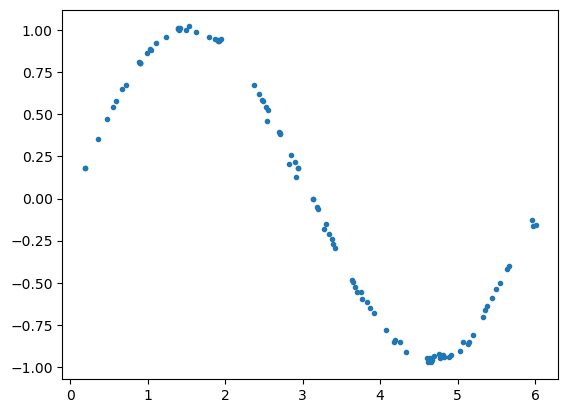

In [30]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
